Derive spec2vec embeddings of MS/MS spectra

In [1]:
import os
import sys
import gensim
import numpy as np

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\Gosia\\Desktop\\'
sys.path.insert(0, ROOT)

Import dataset to create embeddings from, here: pre-processed dataset "Unique InchiKeys"

In [ ]:
import passatuto_parser as pp
sys.path.append('C:\\Users\\Gosia\\Desktop\\FDR-Metabolomics\\src\\passatuto_parser.py')


pre_spectrums_query = pp.PassatutoParser(r'C:\\Users\\Gosia\\Desktop\\MassbankOrbi').parse_folder()
pre_spectrums_lib = pp.PassatutoParser('C:\\Users\\Gosia\\Desktop\\Gnps_Noise_Filtered').parse_folder()

# Using MatchMS to create spectra for both
from matchms.importing.load_from_json import as_spectrum
spectrums_query = []
for i, s in enumerate( pre_spectrums_query ):
    spectrums_query.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)
        
spectrums_lib = []
for i, s in enumerate( pre_spectrums_lib ):
    spectrums_lib.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)
        

In [3]:
from matchms.filtering import normalize_intensities
# Spec2Vec trained model requires normalizing
spectrums_query = [normalize_intensities(s) for s in spectrums_query]
spectrums_lib = [normalize_intensities(s) for s in spectrums_lib]


Load pretrained spec2vec model

In [4]:
path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model")

# Load pretrained model
model = gensim.models.Word2Vec.load(model_file)

Create spectrum "documents"

In [ ]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_query = [SpectrumDocument(s, n_decimals=2) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=2) for s in spectrums_lib]
print(documents_query)



Derive embeddings

In [6]:
from tqdm.notebook import tqdm  # optional, just to get a progress bar
from spec2vec.vector_operations import calc_vector


intensity_weighting_power = 0.5
allowed_missing_percentage = 70 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

vector_size = model.vector_size
print(f"Embedding vector size: {vector_size}")

embeddings_spec2vec_query = np.zeros((len(documents_query), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_query)):
    embeddings_spec2vec_query[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)
embeddings_spec2vec_lib = np.zeros((len(documents_lib), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_lib)):
    embeddings_spec2vec_lib[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

Embedding vector size: 300


Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.32%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.24%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 66 word(s) missing in the model. Weighted missing percentage not covered by the given model is 53.56%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.03%.



In [7]:
print([np.round(x, 4) for x in embeddings_spec2vec_query[0,:]])
print([np.round(x, 4) for x in embeddings_spec2vec_lib[0,:]])

[10.8166, 30.5137, 42.5149, 3.3139, 35.3586, -10.0035, 31.2397, -47.1424, -1.2455, 6.8336, -30.7934, 30.8163, 6.4209, 1.9532, -23.2228, -25.9214, -18.3388, -46.101, 66.0784, -28.9613, 34.9018, -72.261, -8.7241, 41.7448, 10.6812, -29.5364, -79.3635, 7.3907, -53.3976, 49.7313, -67.425, -47.3549, 32.8641, -40.4461, -61.4245, -37.9506, 63.7082, 3.3079, -19.0751, -42.6691, 77.1452, -28.2637, -14.6276, -7.0479, 4.4177, -1.3345, -12.8005, 19.899, -65.0877, -11.9504, -22.8452, -17.3685, -49.6183, -24.7174, 16.6456, -52.0691, -30.1849, 26.8297, 16.679, 22.4903, 41.3793, 44.5005, 115.4647, 36.6748, -68.9138, -8.3474, 48.6162, -15.5162, 37.8943, -14.6371, 45.3029, 20.7899, -38.73, 49.5187, -2.1863, -56.7607, 20.1322, 39.6387, -5.3523, 19.3667, 18.3156, -19.2091, 55.6139, -58.6915, 22.8559, 7.1698, -13.0064, -6.755, -35.7894, -21.5922, 5.6973, -24.7423, -49.0696, -11.9025, 49.41, -7.9325, 45.3136, -41.3073, -33.4759, 17.4322, -9.0041, -5.6946, 56.9676, -28.6833, 35.2828, 19.3479, -44.0346, 83.5209

In [8]:
import scipy 

def s2v_score(embedding_1, embedding_2):
    
    cdist = scipy.spatial.distance.cosine(embedding_1, embedding_2)
    return (1-cdist)


In [9]:
def get_hits(query_vector, lib_vector, documents_query, documents_lib, precursor_tol=1, metaKey='parent_mass', decoys=False, include_impossible_hits=True):
    hits = []
    misses = []
    for q, v in zip( documents_query, query_vector ):
        if metaKey not in q._obj.metadata:
            continue
        else:
            found = decoys
            scores = []
            for l, lv in zip( documents_lib, lib_vector ):
                if abs( q._obj.metadata[metaKey] - l._obj.metadata.get(metaKey,0.0) ) > precursor_tol:
                    continue
                if inchis_equal(q._obj, l._obj):
                    found = True
                s = s2v_score(v, lv)
                if s != s:
                    print('got nan for', q._obj.get('compound_name'))
                    continue
                scores.append((s, l))
            # if all( s[0] == 0.0 for s in scores ):
            #    print(q.get('compound_name'))
            scores.sort(key=lambda x: x[0], reverse=True)
            if not scores:
                misses.append(q)
                continue
            score, target = scores[0]
            if found:
                if decoys:
                    hits.append(Hit(q, target, score, 'decoy'))
                else:
                    hits.append(Hit(q, target, score, inchis_equal(q._obj, scores[0][1]._obj)))
            else:
                misses.append(q)
                if include_impossible_hits:
                    hits.append(Hit(q, target, score, False))
    return hits, misses

In [10]:
def inchis_equal(s1, s2):
    return s1.metadata.get('inchi',"").split("/")[:4] == s2.metadata.get('inchi', "").split("/")[:4]
    # return InchiToInchiKey(s1.metadata['inchi']).split('-')[0] == InchiToInchiKey(s2.metadata['inchi']).split('-')[0]

from collections import namedtuple
import numpy as np

Hit = namedtuple('Hit', ['query', 'target', 'score', 'hit'])


In [11]:
hits,_ = get_hits( embeddings_spec2vec_query, embeddings_spec2vec_lib, documents_query, documents_lib )


In [ ]:
# Loading the decoy database
pre_spectrums_decoys = pp.DecoyParserPassatuto(r'C:\\Users\\Gosia\\Desktop\\GnpsDecoyConditionalPeaks').parse_folder()
pre_spectrums_decoys_rand = pp.DecoyParserPassatuto(r'C:\\Users\\Gosia\\Desktop\\GnpsDecoyRandomPeaks').parse_folder()

In [ ]:
# Using MatchMS to create spectra decoy
decoys = []
for i, s in enumerate( pre_spectrums_decoys ):
    decoys.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d'% i)

decoys_rand = []
for i, s in enumerate( pre_spectrums_decoys_rand ):
    decoys_rand.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d'% i)


In [14]:

from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# Spec2Vec trained model requires normalizing
decoys = [post_process(s) for s in decoys]
decoys_rand = [post_process(s) for s in decoys_rand]
# omit spectrums that didn't qualify for analysis

decoys = [s for s in decoys if s is not None]
decoys_rand = [s for s in decoys_rand if s is not None]

C:\Users\Gosia\anaconda3\envs\fdr-metab\lib\site-packages\matchms\filtering\normalize_intensities.py:21: RuntimeWarning: invalid value encountered in true_divide
  normalized_intensities = intensities / max_intensity


In [15]:
documents_decoys = [SpectrumDocument(s, n_decimals=2) for s in decoys]
documents_decoys_rand = [SpectrumDocument(s, n_decimals=2) for s in decoys_rand]


In [16]:
intensity_weighting_power = 0.5
allowed_missing_percentage = 10 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

vector_size = model.vector_size
print(f"Embedding vector size: {vector_size}")

embeddings_spec2vec_decoys = np.zeros((len(documents_decoys), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_decoys)):
    embeddings_spec2vec_decoys[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)
embeddings_spec2vec_decoys_rand = np.zeros((len(documents_decoys_rand), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_decoys_rand)):
    embeddings_spec2vec_decoys_rand[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

Embedding vector size: 300


In [17]:

def add_pmz(specs):
    from rdkit.Chem import MolFromSmiles, MolToSmiles, MolFromInchi
    from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcMolFormula
    for s in specs:
        s._obj.set('precursor_mz', s._obj.get('parent_mass', 0))
        
add_pmz(documents_query)

In [18]:

hits_decoys,missss = get_hits( embeddings_spec2vec_query, embeddings_spec2vec_decoys, documents_query, documents_decoys, precursor_tol=3,  metaKey="precursor_mz", decoys=True)
hits_decoys_rand,_ = get_hits( embeddings_spec2vec_query, embeddings_spec2vec_decoys_rand, documents_query, documents_decoys_rand, precursor_tol=3, metaKey="precursor_mz", decoys=True)

In [19]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [21]:
# Calculating estimated q-value scores
q_list_estimated = calculate_q_value(hits+hits_decoys,True)
q_list_estimated_rand = calculate_q_value(hits+hits_decoys_rand,True)
print(q_list_estimated)

[(0, True, 0.9758500631928977), (0.0, True, 0.9729620495460636), (0.0, True, 0.9708995815093324), (0.0, True, 0.957731749534336), (0.0, True, 0.9549534996346307), (0.0, True, 0.9454393228356858), (0.0, True, 0.9431926609261765), (0.0, True, 0.9400754117799179), (0.0, True, 0.9380448697244916), (0.0, True, 0.9376780450376974), (0.0, True, 0.9351877027914685), (0.0, True, 0.9238529537911914), (0.0, True, 0.9197115729078361), (0.0, True, 0.9171202307029571), (0.0, True, 0.913192127225209), (0.0, True, 0.9124671017482033), (0.0, True, 0.9102511462661695), (0.0, True, 0.9078108965888338), (0.0, True, 0.9061537208558075), (0.0, True, 0.9040810538456545), (0.0, True, 0.9028355598216621), (0.0, True, 0.9027838420865936), (0.0, True, 0.9021131003033994), (0.0, True, 0.8969807207673839), (0.0, True, 0.8853393667833286), (0.0, True, 0.8825240884370025), (0.0, True, 0.8795129484394975), (0.0, True, 0.8762806550161997), (0.0, True, 0.8727564816865537), (0.0, True, 0.8691195987273651), (0.0, True, 0

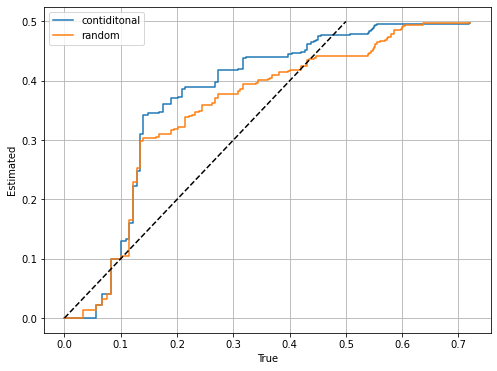

In [22]:
# plot estimated and true q-values
def combine_true_est(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res
        
scores, trues, estimateds = zip(*combine_true_est(q_list_true, q_list_estimated))
scores_rand, trues_rand, estimateds_rand = zip(*combine_true_est(q_list_true, q_list_estimated_rand))

import plot_q_vals
plot_q_vals.plot_q_vals( {'contiditonal':(trues,estimateds), 'random':(trues_rand,estimateds_rand)} )